# Import Library

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from datetime import timedelta

# Data Loading

## COVID Case

In [63]:
dataset = pd.read_csv('covid.csv')
dataset.head()

,harian/key_as_string,harian/key,harian/doc_count,harian/jumlah_meninggal/value,harian/jumlah_sembuh/value,harian/jumlah_positif/value,harian/jumlah_dirawat/value,harian/jumlah_positif_kum/value,harian/jumlah_sembuh_kum/value,harian/jumlah_meninggal_kum/value,harian/jumlah_dirawat_kum/value
0,2020-03-02T00:00:00.000Z,1583107200000,1,0,0,2,2,2,0,0,2
1,2020-03-03T00:00:00.000Z,1583193600000,1,0,0,0,0,2,0,0,2
2,2020-03-04T00:00:00.000Z,1583280000000,1,0,0,0,0,2,0,0,2
3,2020-03-05T00:00:00.000Z,1583366400000,1,0,0,0,0,2,0,0,2
4,2020-03-06T00:00:00.000Z,1583452800000,1,0,0,2,2,4,0,0,4


##### Rename the columns for easier time processing the data

In [64]:
columns_name = {
    'harian/key_as_string': 'date',
    'harian/jumlah_meninggal/value': 'deaths',
    'harian/jumlah_sembuh/value': 'recovered',
    'harian/jumlah_positif/value': 'positive',
    'harian/jumlah_dirawat/value': 'hospitalized',
    'harian/jumlah_positif_kum/value': 'positive_cum',
    'harian/jumlah_sembuh_kum/value': 'recovered_cum',
    'harian/jumlah_meninggal_kum/value': 'deaths_cum',
    'harian/jumlah_dirawat_kum/value': 'hospitalized_cum',
}

data = dataset.rename(columns=columns_name).drop(columns=['harian/key', 'harian/doc_count'])

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.strftime('%Y-%m-%d')

data.head()

,date,deaths,recovered,positive,hospitalized,positive_cum,recovered_cum,deaths_cum,hospitalized_cum
0,2020-03-02,0,0,2,2,2,0,0,2
1,2020-03-03,0,0,0,0,2,0,0,2
2,2020-03-04,0,0,0,0,2,0,0,2
3,2020-03-05,0,0,0,0,2,0,0,2
4,2020-03-06,0,0,2,2,4,0,0,4


#### Check for total number of rows and columns and missing values

In [65]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns')
print(f'The dataset has {data.isnull().sum().sum()} null values')

The dataset has 1000 rows and 9 columns
The dataset has 0 null values


#### Check for the data types of the columns

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              1000 non-null   object
 1   deaths            1000 non-null   int64 
 2   recovered         1000 non-null   int64 
 3   positive          1000 non-null   int64 
 4   hospitalized      1000 non-null   int64 
 5   positive_cum      1000 non-null   int64 
 6   recovered_cum     1000 non-null   int64 
 7   deaths_cum        1000 non-null   int64 
 8   hospitalized_cum  1000 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 70.4+ KB


In [67]:
data.describe()

,deaths,recovered,positive,hospitalized,positive_cum,recovered_cum,deaths_cum,hospitalized_cum
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,159.641000,6424.332000,6646.093000,62.120000,3.000363e+06,2.824214e+06,83792.880000,92355.812000
std,304.088464,9834.764572,10670.505976,6153.400169,2.454453e+06,2.386757e+06,65553.527747,125435.065064
min,0.000000,0.000000,0.000000,-29938.000000,2.000000e+00,0.000000e+00,0.000000,2.000000
25%,16.000000,788.000000,900.750000,-681.750000,4.327705e+05,3.634890e+05,14515.500000,16388.000000
50%,64.500000,3494.500000,3367.000000,79.500000,2.698424e+06,2.166888e+06,69701.000000,48433.000000
75%,164.000000,6351.750000,6278.250000,702.250000,5.969048e+06,5.617216e+06,153934.500000,109546.500000
max,2069.000000,61361.000000,64718.000000,39165.000000,6.646093e+06,6.424332e+06,159641.000000,586113.000000


## Vaccination

In [68]:
data_vac = pd.read_csv('vaksinasi.csv').drop([0])
data_vac

,key_as_string,key,doc_count,jumlah_vaksinasi_2/value,jumlah_vaksinasi_1/value,jumlah_jumlah_vaksinasi_1_kum/value,jumlah_jumlah_vaksinasi_2_kum/value
1,2021-02-02,1612224000000,0,0,0,0,0
2,2021-02-03,1612310400000,0,0,0,0,0
3,2021-02-04,1612396800000,0,0,0,0,0
4,2021-02-05,1612483200000,0,0,0,0,0
5,2021-02-06,1612569600000,0,0,0,0,0
...,...,...,...,...,...,...,...
671,2022-12-04,1670112000000,1,32364,22532,203730045,174292461
672,2022-12-05,1670198400000,1,11137,5564,203735609,174303598
673,2022-12-06,1670284800000,1,19545,9595,203745204,174323143
674,2022-12-07,1670371200000,1,22743,14334,203759538,174345886


In [69]:
columns_name = {
    'key_as_string': 'date',
    'jumlah_jumlah_vaksinasi_1_kum/value': 'vaccine-1',
    'jumlah_jumlah_vaksinasi_2_kum/value': 'vaccine-2',
}

columns_to_drop = ['key', 'doc_count', 'jumlah_vaksinasi_1/value', 'jumlah_vaksinasi_2/value' ]

data_vac = data_vac.rename(columns=columns_name).drop(columns_to_drop, axis=1)

data_vac['date'] = pd.to_datetime(data_vac['date'])

cols = list(data_vac.columns.values)
cols.pop(cols.index('vaccine-2'))
data_vac = data_vac[cols+['vaccine-2']]

data_vac.head()

,date,vaccine-1,vaccine-2
1,2021-02-02,0,0
2,2021-02-03,0,0
3,2021-02-04,0,0
4,2021-02-05,0,0
5,2021-02-06,0,0


In [70]:
data_vac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 1 to 675
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       675 non-null    datetime64[ns]
 1   vaccine-1  675 non-null    int64         
 2   vaccine-2  675 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 15.9 KB


In [71]:
data_vac.describe()

,vaccine-1,vaccine-2
count,6.750000e+02,6.750000e+02
mean,1.277472e+08,9.805065e+07
std,7.994182e+07,6.889741e+07
min,0.000000e+00,0.000000e+00
25%,4.247814e+07,1.652898e+07
50%,1.672262e+08,1.148226e+08
75%,2.012600e+08,1.686171e+08
max,2.054092e+08,1.743935e+08


# Data preprocessing

## Merge COVID and Vaccination Data

In [72]:
covid_df = data.copy().drop(['positive_cum', 'recovered_cum', 'deaths_cum', 'hospitalized_cum'], axis=1)
vaccine_df = data_vac.copy()
vaccine_df['date'] = vaccine_df['date'].dt.strftime('%Y-%m-%d')
covid_df = covid_df.merge(vaccine_df, on='date', how='inner')
covid_df.head()

,date,deaths,recovered,positive,hospitalized,vaccine-1,vaccine-2
0,2021-02-02,304,12848,10379,-2773,0,0
1,2021-02-03,189,9135,11984,2660,0,0
2,2021-02-04,231,11641,11434,-438,0,0
3,2021-02-05,201,9674,11749,1874,0,0
4,2021-02-06,191,12204,12156,-239,0,0


In [73]:
print(f'The dataset has {covid_df.shape[0]} rows and {covid_df.shape[1]} columns')
print(f'The dataset has {covid_df.isnull().sum().sum()} null values')

The dataset has 663 rows and 7 columns
The dataset has 0 null values


## Break down the date into day, month, year

In [74]:
data['day'] = pd.DatetimeIndex(data['date']).day
data['month'] = pd.DatetimeIndex(data['date']).month
data['year'] = pd.DatetimeIndex(data['date']).year

## Dropping negative values in the hospitalized data

In [75]:
data_hospitalized = data[['date', 'hospitalized', 'month', 'year']]
data_hospitalized = data_hospitalized[data_hospitalized['hospitalized'] >= 0]
data_hospitalized_monthly = data_hospitalized.groupby('month').agg(np.mean).reset_index()
data_hospitalized_yearly= data_hospitalized.groupby('year').sum().reset_index()
data_hospitalized.head()

,date,hospitalized,month,year
0,2020-03-02,2,3,2020
1,2020-03-03,0,3,2020
2,2020-03-04,0,3,2020
3,2020-03-05,0,3,2020
4,2020-03-06,2,3,2020


# Exploratory Data Analysis

The dataset has 663 rows and 7 columns with the following columns:
* date - date of observation
* deaths - number of deaths
* recovered - number of recovered cases
* positive - number of positive cases
* hospitalized - number of hospitalized cases
* vaccine-1 - number of people who received the first dose of vaccine
* vaccine-2 - number of people who received the second dose of vaccine

## Univariate Analysis

### COVID Case

#### Positive Cases

In [76]:
monthly = data.groupby('month').agg(np.mean).reset_index()
yearly = data.groupby('year').sum().reset_index()

fig = make_subplots(rows=3, cols=1, subplot_titles=('Daily', 'Average Monthly', 'Total Yearly'))

fig.append_trace(px.line(data, x='date', y='positive').data[0], row=1, col=1)
fig.append_trace(px.line(monthly, x='month', y='positive').data[0], row=2, col=1)
fig.append_trace(px.line(yearly, x='year', y='positive').data[0], row=3, col=1)

fig.update_layout(height=800, width=800, title_text="Positive Cases")

fig.show()

The third wave of COVID-19 positive cases was caused by the Omicron variant which is more infectious than the previous variants.

#### Recovered Cases

In [77]:
fig = make_subplots(rows=3, cols=1, subplot_titles=('Daily', 'Average Monthly', 'Total Yearly'))

fig.append_trace(px.line(data, x='date', y='recovered').data[0], row=1, col=1)
fig.append_trace(px.line(monthly, x='month', y='recovered').data[0], row=2, col=1)
fig.append_trace(px.line(yearly, x='year', y='recovered').data[0], row=3, col=1)

fig.update_layout(height=800, width=800, title_text="Recovered Cases")

fig.show()

The third wave of COVID-19 recovered cases was higher because the Omicron variant was less severe than the Delta variant ( the second wave ).

#### Death Cases

In [78]:
fig = make_subplots(rows=3, cols=1, subplot_titles=('Daily', 'Average Monthly', 'Total Yearly'))

fig.append_trace(px.line(data, x='date', y='deaths').data[0], row=1, col=1)
fig.append_trace(px.line(monthly, x='month', y='deaths').data[0], row=2, col=1)
fig.append_trace(px.line(yearly, x='year', y='deaths').data[0], row=3, col=1)

fig.update_layout(height=800, width=800, title_text="Deaths Cases")

fig.show()

The third wave of COVID-19 death cases was lower because the Omicron variant was less lethal than the Delta variant ( the second wave ).

#### Hospitalized Cases

In [79]:
fig = make_subplots(rows=3, cols=1, subplot_titles=('Daily', 'Average Monthly', 'Total Yearly'))

fig.append_trace(px.line(data_hospitalized, x='date', y='hospitalized').data[0], row=1, col=1)
fig.append_trace(px.line(data_hospitalized_monthly, x='month', y='hospitalized').data[0], row=2, col=1)
fig.append_trace(px.line(data_hospitalized_yearly, x='year', y='hospitalized').data[0], row=3, col=1)

fig.update_layout(height=800, width=800, title_text="Hospitalized Cases")

fig.show()

The third wave of COVID-19 hospitalized cases was higher because the Omicron variant was more infectious than the Delta variant ( the second wave ) yet less lethal and treatable.

## Bivariate Analysis

### Vaccination

In [80]:
fig = px.line(data_vac, x='date', y=['vaccine-1', 'vaccine-2'])
fig.update_layout(height=800, width=800, title_text="Vaccination")
fig.show()

Vaccination has peaked on January 2022 and start being stagnant since then.

## Multi-variate Analysis

### Positive cases with vaccination

In [81]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['positive'], name="Positive Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-1'], name="Vaccine-1"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-2'], name="Vaccine-2"),
    secondary_y=True,
)
fig.update_layout(height=800, width=800, title_text="Positive Cases and Vaccination")
fig.show()

The positive cases has been decreasing since the third wave of COVID-19. Showing that the vaccination is effective in reducing the number of positive cases.

### Recovered cases with vaccination

In [82]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['recovered'], name="Recovered Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-1'], name="Vaccine-1"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-2'], name="Vaccine-2"),
    secondary_y=True,
)
fig.update_layout(height=800, width=800, title_text="Recovered Cases and Vaccination")
fig.show()

As the number of people who received the first and second dose of vaccine increases, the number of recovered cases also increases. Showing that the vaccine is effective in helping the infected to recover from COVID-19.

### Death cases with vaccination

In [83]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['deaths'], name="Deaths Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-1'], name="Vaccine-1"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-2'], name="Vaccine-2"),
    secondary_y=True,
)
fig.update_layout(height=800, width=800, title_text="Deaths Cases and Vaccination")
fig.show()

As the number of people who received the first and second dose of vaccine increases, the number of death cases also decreases. Showing that the vaccine is effective in preventing severe symptoms that might lead to an increase in lethality.

### Hospitalized cases with vaccination

In [84]:
data_hospitalized = data_hospitalized[data_hospitalized['date'] >= '2021-02-02']

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=data_hospitalized['date'], y=data_hospitalized['hospitalized'], name="Hospitalized Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-1'], name="Vaccine-1"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['vaccine-2'], name="Vaccine-2"),
    secondary_y=True,
)
fig.update_layout(height=800, width=800, title_text="Hospitalized Cases and Vaccination")
fig.show()

During the third wave of COVID-19, hospitalized cases didn't decrease. Showing that the vaccine is not that effective in preventing symptoms that need to be treated in hospitals in a short time period after vaccination. But after the third wave of COVID-19, the number of hospitalized cases has been decreasing. Showing that the vaccine is indeed effective in preventing severe symptoms that might lead to an increase in hospitalization after some time period of the vaccination.

### Positive cases, recovered cases, deaths cases, hospitalized cases

In [85]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['positive'], name="Positive Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['deaths'], name="Deaths Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=covid_df['date'], y=covid_df['recovered'], name="Recovered Cases"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=data_hospitalized['date'], y=data_hospitalized['hospitalized'], name="Hospitalized Cases"),
    secondary_y=False,
)

fig.update_layout(height=800, width=800, title_text="Positive Cases, Deaths Cases, Recovered Cases, Hospitalized Cases")
fig.show()

Positive cases, recovered cases and hospitalized cases are proportional. The more people are infected, the more people recover and the more people are hospitalized.

For the death cases, it is correlating but not proportional. The more people are infected, the more people die. But the number of death cases is not proportional to the number of positive cases. The number of death cases is more proportional to the number of hospitalized cases.

Text(0.5, 1.0, 'Correlation matrix for numerical features')

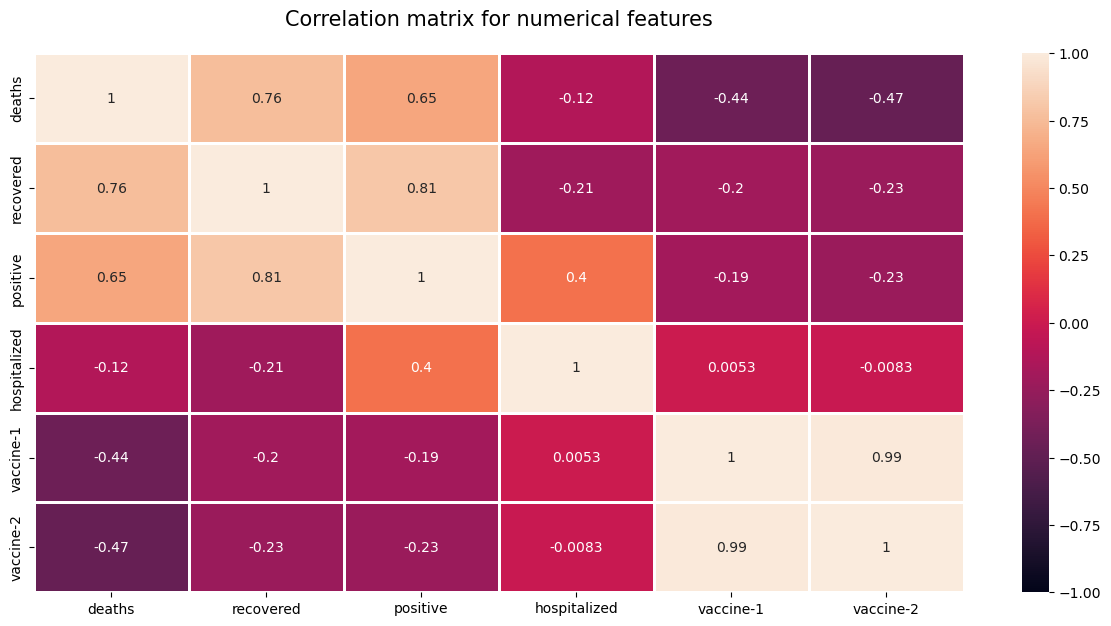

In [86]:
plt.figure(figsize=(15,7))
sns.heatmap(covid_df.corr(), annot=True, vmin=-1, vmax=1, linewidth=1)
plt.title('Correlation matrix for numerical features', size=15, pad=20)

# Data Preparation

In [87]:
target = 'positive'
features = ['deaths', 'recovered']
test_size = 0.1

df = covid_df.copy()
df = df[['date', target, *features]]

df.head()

,date,positive,deaths,recovered
0,2021-02-02,10379,304,12848
1,2021-02-03,11984,189,9135
2,2021-02-04,11434,231,11641
3,2021-02-05,11749,201,9674
4,2021-02-06,12156,191,12204


#### Shift the positive column by 1 day to be used as predictor for the next day

In [88]:
df['y'] = df[target].shift(-1)
df

,date,positive,deaths,recovered,y
0,2021-02-02,10379,304,12848,11984.0
1,2021-02-03,11984,189,9135,11434.0
2,2021-02-04,11434,231,11641,11749.0
3,2021-02-05,11749,201,9674,12156.0
4,2021-02-06,12156,191,12204,10827.0
...,...,...,...,...,...
658,2022-11-22,7644,51,4984,7221.0
659,2022-11-23,7221,51,4903,7110.0
660,2022-11-24,7110,41,7669,5976.0
661,2022-11-25,5976,35,6752,5469.0


In [89]:
train, test = train_test_split(df, test_size=test_size, shuffle=False)
print(f'Train size: {len(train)}, Test size: {len(test)}')

Train size: 596, Test size: 67


#### Drop the last row because it has no predictor for the next day

In [90]:
test = test.drop(test.tail(1).index)

#### Set a baseline to compare the model performance of the machine learning model performance versus non-machine learning performance.

In [91]:
test['baseline_pred'] = test[target]
test

,date,positive,deaths,recovered,y,baseline_pred
596,2022-09-21,2384,18,2991,2162.0,2384
597,2022-09-22,2162,18,4051,1904.0,2162
598,2022-09-23,1904,20,3077,1724.0,1904
599,2022-09-24,1724,12,2040,1411.0,1724
600,2022-09-25,1411,16,2569,1344.0,1411
...,...,...,...,...,...,...
657,2022-11-21,4306,43,6855,7644.0,4306
658,2022-11-22,7644,51,4984,7221.0,7644
659,2022-11-23,7221,51,4903,7110.0,7221
660,2022-11-24,7110,41,7669,5976.0,7110


# Fitting the models: DecisionTree, RandomForest, GradientBoost

## Helper methods

In [92]:
def evaluate(models, X_test, y_test):
    for model in models:
        y_pred = model.predict(X_test)
        print(f'{model.__class__.__name__} MAE: {mae(y_test, y_pred)}')
        print(f'{model.__class__.__name__} MSE: {mse(y_test, y_pred)}')
        print(f'{model.__class__.__name__} RMSE: {np.sqrt(mse(y_test, y_pred))}')
        print(f'{model.__class__.__name__} R2: {r2_score(y_test, y_pred)}')
        print(f'{model.__class__.__name__} MAPE: {mape(y_test, y_pred) * 100}')
        print()

models = ['Random Forest', 'Gradient Boosting', 'Baseline']

## Positive cases

### Predict the next time step using previous time step

In [93]:
X_train = train[[target, *features]]
y_train = train['y'].values.reshape(-1,1)
X_test = test[[target, *features]]

In [94]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]})

In [95]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",rf_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",rf_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",rf_grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=5,
                      min_samples_split=12, n_estimators=1000, random_state=42)

 The best score across ALL searched params:
 0.9144292221276049

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 1000}


In [96]:
rf_params = rf_grid.best_params_
rf_params

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 1000}

In [97]:
rf_reg = RandomForestRegressor(random_state=42, **rf_params)
rf_reg.fit(X=X_train, y=y_train.ravel())
rf_pred = rf_reg.predict(X_test)
test['rf_pred'] = rf_pred

In [98]:
parameters = {
  'learning_rate': [0.01,0.02,0.03,0.04],
  'subsample'    : [0.9, 0.5, 0.2, 0.1],
  'n_estimators' : [100,500,1000, 1500],
  'max_depth'    : [4,6,8,10]
}
                    
gbr = GradientBoostingRegressor(random_state=42)
gbr_grid = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 2, n_jobs=-1)
gbr_grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [99]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gbr_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",gbr_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",gbr_grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=500,
                          random_state=42, subsample=0.1)

 The best score across ALL searched params:
 0.9348629231810242

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.1}


In [100]:
gbr_params = gbr_grid.best_params_
gbr_params

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.1}

In [101]:
gbr = GradientBoostingRegressor(random_state=42, **gbr_params)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

### Plot the predicted values

In [102]:
fig = make_subplots(rows=1, cols=3, subplot_titles=models)


fig.append_trace(px.line(test, x='date', y=target, color_discrete_sequence=['#000000']).data[0], row=1, col=1)
fig.append_trace(px.line(test, x='date', y='rf_pred', color_discrete_sequence=['#FF0000']).data[0], row=1, col=1)

fig.append_trace(px.line(test, x='date', y=target, color_discrete_sequence=['#000000']).data[0], row=1, col=2)
fig.append_trace(px.line(test, x='date', y='gbr_pred', color_discrete_sequence=['#FF0000']).data[0], row=1, col=2)

fig.append_trace(px.line(test, x='date', y='y', color_discrete_sequence=['#000000']).data[0], row=1, col=3)
fig.append_trace(px.line(test, x='date', y='baseline_pred', color_discrete_sequence=['#FF0000']).data[0], row=1, col=3)


fig.update_layout(height=600, width=1200, title_text="Prediction")
fig.show()

In [103]:
evaluate([rf_reg, gbr], X_test, test['y'])

RandomForestRegressor MAE: 588.0063136307199
RandomForestRegressor MSE: 818234.9401630262
RandomForestRegressor RMSE: 904.5633975366383
RandomForestRegressor R2: 0.8204328593087176
RandomForestRegressor MAPE: 19.114574902072658

GradientBoostingRegressor MAE: 568.8012135318813
GradientBoostingRegressor MSE: 810970.4141585771
GradientBoostingRegressor RMSE: 900.5389576018225
GradientBoostingRegressor R2: 0.8220271082206945
GradientBoostingRegressor MAPE: 16.981294751851244



### Evaluate the model performance

#### MAE

In [104]:
fig = go.Figure(data=[
    go.Bar(name='Baseline', x=['mae'], y=[mae(test['y'], test['baseline_pred'])]),
    go.Bar(name='Random Forest', x=['mae'], y=[mae(test['y'], test['rf_pred'])]),
    go.Bar(name='Gradient Boosting', x=['mae'], y=[mae(test['y'], test['gbr_pred'])])
])

fig.update_layout(barmode='group', title_text='MAE')
fig.show()

#### MSE

In [105]:
fig = go.Figure(data=[
    go.Bar(name='Baseline', x=['mse'], y=[mse(test['y'], test['baseline_pred'])]),
    go.Bar(name='Random Forest', x=['mse'], y=[mse(test['y'], test['rf_pred'])]),
    go.Bar(name='Gradient Boosting', x=['mse'], y=[mse(test['y'], test['gbr_pred'])])
])

fig.update_layout(barmode='group', title_text='MSE')
fig.show()

#### RMSE

In [106]:
fig = go.Figure(data=[
    go.Bar(name='Baseline', x=['rmse'], y=[np.sqrt(mse(test['y'], test['baseline_pred']))]),
    go.Bar(name='Random Forest', x=['rmse'], y=[np.sqrt(mse(test['y'], test['rf_pred']))]),
    go.Bar(name='Gradient Boosting', x=['rmse'], y=[np.sqrt(mse(test['y'], test['gbr_pred']))])
])

fig.update_layout(barmode='group', title_text='RMSE')
fig.show()

#### R-squared

In [107]:
fig = go.Figure(data=[
    go.Bar(name='Baseline', x=['r2'], y=[r2_score(test['y'], test['baseline_pred'])]),
    go.Bar(name='Random Forest', x=['r2'], y=[r2_score(test['y'], test['rf_pred'])]),
    go.Bar(name='Gradient Boosting', x=['r2'], y=[r2_score(test['y'], test['gbr_pred'])])
])

fig.update_layout(barmode='group', title_text='R2')
fig.show()

#### MAPE

In [108]:
fig = go.Figure(data=[
    go.Bar(name='Baseline', x=['MAPE'], y=[mape(test['y'], test['baseline_pred']) * 100]),
    go.Bar(name='Random Forest', x=['MAPE'], y=[mape(test['y'], test['rf_pred']) * 100]),
    go.Bar(name='Gradient Boosting', x=['MAPE'], y=[mape(test['y'], test['gbr_pred']) * 100])
])

fig.update_layout(barmode='group', title_text='MAPE')
fig.show()

# Forecast

## Forecast based on previous time step

### Get last date of the dataset

In [109]:
def get_last_data(data):
    last_data = data[-1:].drop(['y'], axis=1)
    last_data['date'] = pd.to_datetime(last_data['date'])
    last_data = last_data.reset_index(drop=True)
    print(last_data)
    return last_data

### Forecast the next 7 days

#### Random Forest

In [110]:
last_data = get_last_data(df)

        date  positive  deaths  recovered
0 2022-11-26      5469      41       6360


In [111]:
forecast_week_df = pd.DataFrame()

for i in range(7):
    pred = rf_reg.predict(last_data[[target, *features]])
    date = last_data['date'] + timedelta(days=1)
    last_data['date'] = date
    last_data['positive'] = pred
    forecast_week_df = pd.concat([forecast_week_df, last_data], axis=0)

forecast_week_df = forecast_week_df[['date', 'positive']]
forecast_week_df

,date,positive
0,2022-11-27,5204.828745
0,2022-11-28,4982.451115
0,2022-11-29,4890.530725
0,2022-11-30,5062.750614
0,2022-12-01,4911.616621
0,2022-12-02,5000.512835
0,2022-12-03,4886.430713


### Plot the forecast

In [112]:
fig = px.line(df, x='date', y='positive', color_discrete_sequence=['#000000'])

fig.add_trace(px.line(forecast_week_df, x='date', y='positive', color_discrete_sequence=['#FF0000']).data[0])

fig.update_layout(height=400, width=800, title_text="Forecast")

fig.show()

#### Gradient Boosting

In [113]:
last_data = get_last_data(df)

        date  positive  deaths  recovered
0 2022-11-26      5469      41       6360


In [114]:
forecast_week_df = pd.DataFrame()

for i in range(7):
    pred = gbr.predict(last_data[[target, *features]])
    date = last_data['date'] + timedelta(days=1)
    last_data['date'] = date
    last_data['positive'] = pred
    forecast_week_df = pd.concat([forecast_week_df, last_data], axis=0)

forecast_week_df = forecast_week_df[['date', 'positive']]
forecast_week_df

,date,positive
0,2022-11-27,5086.882576
0,2022-11-28,4888.624513
0,2022-11-29,4971.243957
0,2022-11-30,4902.694355
0,2022-12-01,4901.393995
0,2022-12-02,4901.393995
0,2022-12-03,4901.393995


### Plot the forecast

In [115]:
fig = px.line(df, x='date', y='positive', color_discrete_sequence=['#000000'])

fig.add_trace(px.line(forecast_week_df, x='date', y='positive', color_discrete_sequence=['#FF0000']).data[0])

fig.update_layout(height=400, width=800, title_text="Forecast")

fig.show()